# 190118, 영->한 번역 train.py 커스터마이징
본래 코드가 짜쯩나서 쥬피터로 다시짬.


In [1]:
import sys, os.path

import torch
import torch.nn as nn

from data_loader import DataLoader
import data_loader

from simple_nmt.seq2seq import Seq2Seq
from simple_nmt.rnnlm import LanguageModel

# from simple_nmt.trainer import Trainer
from simple_nmt.trainer_custom import Trainer
# from simple_nmt.rl_trainer import MinimumRiskTrainer
from simple_nmt.rl_trainer_custom import MinimumRiskTrainer

from simple_nmt.dual_trainer import DualTrainer
from simple_nmt.lm_trainer import LanguageModelTrainer

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
class Myconfig():
    def __init__(self):
        self.n_epochs       = 40  #22  # Number of epochs
        self.rl_n_epochs    = 20  #15  # Number of epochs for reinforcement learning. Default=10
        self.model          = './models/enko.pth'  # model file name
        self.train          = './data/corpus.train'  # Training set file name except the extention. (ex: train.en --> train)
        self.valid          = './data/corpus.valid'  # Validation set file name except the extention. (ex: valid.en --> valid)
        self.lang           = 'enko'  # Set of extention represents language pair. (ex: en + ko --> enko)
        self.gpu_id         = 0
        self.batch_size     = 32
        self.verbose        = 1   # 0,1,2
        self.early_stop     = 15   # 0 : on
        self.max_length     = 80  # Maximum length of the training sequence. Default=80
        self.dropout        = 0.2
        self.word_vec_dim   = 256  # Word embedding vector dimension. Default=512
        self.hidden_size    = 512  # Hidden size of LSTM. Default=768
        self.n_layers       = 4  # Number of layers in LSTM. Default=4'   
        self.max_grad_norm  = 5.  # Threshold for gradient clipping. Default=5.0
        self.adam           = False # SGD or ADAM, Use Adam instead of using SGD.
        self.lr             = 1  #0.001          # Initial learning rate. Default=1.0
        self.min_lr         = 0.000001  # Minimum learning rate. Default=.000001
        self.lr_decay_start_at = 10  # Start learning rate decay from this epoch, 10 이상부턴 learning rate decay 적용
        self.lr_slow_decay  ='store_true'  # Decay learning rate only if there is no improvement on last epoch
        self.lr_decay_rate  = 0.5  # Learning rate decay rate. Default=0.5
        self.train_ratio_per_epoch = 1.  # Ratio of using train-set in one training epoch. Default=1
        self.dsl            = 'store_true'  # Training with Dual Supervised Learning method
        self.lm_n_epochs    = 10  # Number of epochs for language model training. Default=5
        self.dsl_n_epochs   = 10  # Number of epochs for Dual Supervised Learning. \'--n_epochs\' - \'--dsl_n_epochs\' will be number of epochs for pretraining (without regularization term)
        self.dsl_lambda     = 1e-3  # Lagrangian Multiplier for regularization term. Default=1e-3
        self.dsl_retrain_lm = 'store_true'  # Retrain the language models whatever
        self.dsl_continue_train_lm = 'store_true'  # Continue to train the language models watever
        self.rl_lr          = 0.01  # Learning rate for reinforcement learning. Default=.01
        self.n_samples      = 1  # Number of samples to get baseline. Default=1
        self.rl_n_gram      = 6 # Maximum number of tokens to calculate BLEU for reinforcement learning. Default=6

config = Myconfig()
def _print_config(config):
    import pprint
    pp = pprint.PrettyPrinter(indent=4)
    pp.pprint(vars(config))
_print_config(config)

{   'adam': False,
    'batch_size': 32,
    'dropout': 0.2,
    'dsl': 'store_true',
    'dsl_continue_train_lm': 'store_true',
    'dsl_lambda': 0.001,
    'dsl_n_epochs': 10,
    'dsl_retrain_lm': 'store_true',
    'early_stop': 15,
    'gpu_id': 0,
    'hidden_size': 512,
    'lang': 'enko',
    'lm_n_epochs': 10,
    'lr': 1,
    'lr_decay_rate': 0.5,
    'lr_decay_start_at': 10,
    'lr_slow_decay': 'store_true',
    'max_grad_norm': 5.0,
    'max_length': 80,
    'min_lr': 1e-06,
    'model': './models/enko.pth',
    'n_epochs': 40,
    'n_layers': 4,
    'n_samples': 1,
    'rl_lr': 0.01,
    'rl_n_epochs': 20,
    'rl_n_gram': 6,
    'train': './data/corpus.train',
    'train_ratio_per_epoch': 1.0,
    'valid': './data/corpus.valid',
    'verbose': 1,
    'word_vec_dim': 256}


In [3]:
# If the model exists, load model and configuration to continue the training.
if os.path.isfile(config.model):
    saved_data = torch.load(config.model, map_location='cpu' if config.gpu_id < 0 else 'cuda:%d' % config.gpu_id)

    prev_config = saved_data['config']
    config = overwrite_config(config, prev_config)
    config.lr = saved_data['current_lr'] if saved_data.get('current_lr') is not None else config.lr
else:
    saved_data = None

In [4]:
# Load training and validation data set.
loader = DataLoader(config.train,
                    config.valid,
                    (config.lang[:2], config.lang[-2:]),
                    batch_size=config.batch_size,
                    device=config.gpu_id,
                    max_length=config.max_length,
                    dsl=config.dsl
                    )

In [5]:
# Encoder's embedding layer input size
input_size = len(loader.src.vocab)
# Decoder's embedding layer input size and Generator's softmax layer output size
output_size = len(loader.tgt.vocab)

# Declare the model
model = Seq2Seq(input_size,               # src vocab size
                config.word_vec_dim,      # Word embedding vector size
                config.hidden_size,       # LSTM's hidden vector size
                output_size,              # tgt vocab size
                n_layers=config.n_layers, # number of layers in LSTM
                dropout_p=config.dropout  # dropout-rate in LSTM
                )
print('model loaded')

model loaded


In [6]:
# Default weight for loss equals to 1, but we don't need to get loss for PAD token.
# Thus, set a weight for PAD to zero.
# PAD는 고려하지 않으려고
loss_weight = torch.ones(output_size)  
loss_weight[data_loader.PAD] = 0.      
# Instead of using Cross-Entropy loss, we can use Negative Log-Likelihood(NLL) loss    with log-probability.
crit = nn.NLLLoss(weight=loss_weight, 
                  reduction='sum'
                  )
print(model)
print(crit)

# Pass models to GPU device if it is necessary.
if config.gpu_id >= 0:
    print('use gpu')
    model.cuda(config.gpu_id)
    crit.cuda(config.gpu_id)

Seq2Seq(
  (emb_src): Embedding(2430, 256)
  (emb_dec): Embedding(3683, 256)
  (encoder): Encoder(
    (rnn): LSTM(256, 256, num_layers=4, batch_first=True, dropout=0.2, bidirectional=True)
  )
  (decoder): Decoder(
    (rnn): LSTM(768, 512, num_layers=4, batch_first=True, dropout=0.2)
  )
  (attn): Attention(
    (linear): Linear(in_features=512, out_features=512, bias=False)
    (softmax): Softmax()
  )
  (concat): Linear(in_features=1024, out_features=512, bias=True)
  (tanh): Tanh()
  (generator): Generator(
    (output): Linear(in_features=512, out_features=3683, bias=True)
    (softmax): LogSoftmax()
  )
)
NLLLoss()
use gpu


In [7]:
# Start training. This function maybe equivalant to 'fit' function in Keras.
trainer_class = Trainer(model,
                        crit,
                        config=config,
                        src_vocab=loader.src.vocab,
                        tgt_vocab=loader.tgt.vocab
                        )
# If we have loaded model weight parameters, use that weights for declared model.
if saved_data is not None:
    trainer_class.best = saved_data  #  
    trainer_class.get_best_model()

In [8]:
## 훈련 시작!
train_loss, valid_loss = trainer_class.train(loader.train_iter, loader.valid_iter)

train start - epoch : 40 / 2019-01-18 17:04:14.864836
epoch: 1/40	loss_tran / valid:7.2269e+00 / 5.9198e+00	current_lr:1.000000
epoch: 2/40	loss_tran / valid:6.0717e+00 / 5.2006e+00	current_lr:1.000000
epoch: 3/40	loss_tran / valid:5.0874e+00 / 4.4694e+00	current_lr:1.000000
epoch: 4/40	loss_tran / valid:4.3968e+00 / 3.9161e+00	current_lr:1.000000
epoch: 5/40	loss_tran / valid:3.7611e+00 / 3.4903e+00	current_lr:1.000000
epoch: 6/40	loss_tran / valid:3.1784e+00 / 2.9290e+00	current_lr:1.000000
epoch: 7/40	loss_tran / valid:2.6899e+00 / 2.5307e+00	current_lr:1.000000
epoch: 8/40	loss_tran / valid:2.2499e+00 / 2.2094e+00	current_lr:1.000000
epoch: 9/40	loss_tran / valid:1.8973e+00 / 2.0126e+00	current_lr:1.000000
epoch: 10/40	loss_tran / valid:1.6025e+00 / 1.7852e+00	current_lr:1.000000
epoch: 11/40	loss_tran / valid:1.0941e+00 / 1.4386e+00	current_lr:0.500000
epoch: 12/40	loss_tran / valid:7.8954e-01 / 1.3302e+00	current_lr:0.250000
epoch: 13/40	loss_tran / valid:6.3895e-01 / 1.2564e+00	

# 강화학습
훈련된 모델에 BLEU값을 더 높이기 위해 loss에 반영하여 성능 더 높이기
Minimum Risk Training 방법이라고 불림

In [9]:
## !! Start reinforcement learning.
if config.rl_n_epochs > 0:
    print('Reinforcement Learning Start')
    rl_trainer = MinimumRiskTrainer(model,
                                    crit,
                                    config=config,
                                    src_vocab=loader.src.vocab,
                                    tgt_vocab=loader.tgt.vocab,
                                    )
    if saved_data is not None:
        rl_trainer.best = saved_data
        if rl_trainer.best['epoch'] == config.n_epochs:
            rl_trainer.best['current_lr'] = config.rl_lr
        rl_trainer.get_best_model()
    train_BLEU, valid_BLEU = rl_trainer.train(loader.train_iter, loader.valid_iter)

Reinforcement Learning Start
train start - epoch : 60 / 2019-01-18 17:18:26.108898
epoch: 41/60	loss_tran / valid:5.5169e+01 / 6.0028e+01	current_lr:0.010000
epoch: 42/60	loss_tran / valid:5.5507e+01 / 6.0894e+01	current_lr:0.010000
epoch: 43/60	loss_tran / valid:5.5759e+01 / 6.0556e+01	current_lr:0.010000
epoch: 44/60	loss_tran / valid:5.6222e+01 / 5.9706e+01	current_lr:0.010000
epoch: 45/60	loss_tran / valid:5.6880e+01 / 5.8821e+01	current_lr:0.010000
epoch: 46/60	loss_tran / valid:5.7003e+01 / 5.8176e+01	current_lr:0.010000
epoch: 47/60	loss_tran / valid:5.7318e+01 / 5.8793e+01	current_lr:0.010000
epoch: 48/60	loss_tran / valid:5.7549e+01 / 5.8297e+01	current_lr:0.010000
epoch: 49/60	loss_tran / valid:5.7789e+01 / 5.8830e+01	current_lr:0.010000
epoch: 50/60	loss_tran / valid:5.8177e+01 / 5.8994e+01	current_lr:0.010000
epoch: 51/60	loss_tran / valid:5.8355e+01 / 5.8307e+01	current_lr:0.010000
epoch: 52/60	loss_tran / valid:5.8475e+01 / 5.8473e+01	current_lr:0.010000
epoch: 53/60	loss

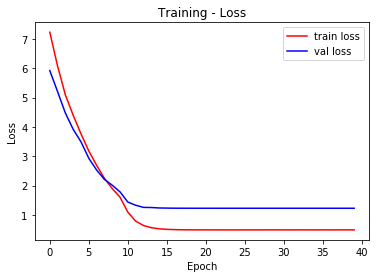

In [12]:
## !! plot
fig, loss_ax = plt.subplots()
loss_ax.plot(train_loss, 'r', label='train loss')
loss_ax.plot(valid_loss, 'b', label='val loss')
loss_ax.set_xlabel('Epoch')
loss_ax.set_ylabel('Loss')
loss_ax.legend(loc='upper right')
plt.title('Training - Loss')
plt.show()

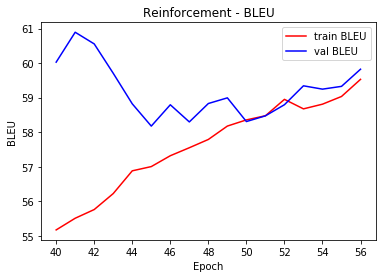

In [13]:
## !! plot
fig, loss_ax = plt.subplots()
x = range(config.n_epochs, config.n_epochs+len(train_BLEU))
loss_ax.plot(x, train_BLEU, 'r', label='train BLEU')
loss_ax.plot(x, valid_BLEU, 'b', label='val BLEU')
loss_ax.set_xlabel('Epoch')
loss_ax.set_ylabel('BLEU')
loss_ax.legend(loc='upper right')
plt.title('Reinforcement - BLEU')
plt.show()